In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
file_path = '/Users/ekinyilmaz/Desktop/mentalab/EMGData/emg_data3.csv'  # Update with your file path
emg_data_ex = pd.read_csv(file_path)

# List of EMG recordings
"""
recordings = {'emg_data1': '/Users/ekinyilmaz/Desktop/mentalab/EMGData/emg_data1.csv',
              'emg_data2': '/Users/ekinyilmaz/Desktop/mentalab/EMGData/emg_data2.csv',
              'emg_data3': '/Users/ekinyilmaz/Desktop/mentalab/EMGData/emg_data3.csv',
              'emg_data4': '/Users/ekinyilmaz/Desktop/mentalab/EMGData/emg_data4.csv',
              'emg_data5': '/Users/ekinyilmaz/Desktop/mentalab/EMGData/emg_data5.csv'}
"""
# Output directory to save segments
output_directory = '/Users/ekinyilmaz/Desktop/mentalab/segments'

In [7]:
# Display the first few rows of the DataFrame
display(emg_data_ex.head())

TimeStamp       ECR     FCR      ECU      FCU
0  312415.7197 -10783.96 -371.50 -1579.67 -4242.33
1  312415.7207 -10858.97 -446.51 -1645.76 -4305.36
2  312415.7217 -10984.95 -576.45 -1776.65 -4424.05
3  312415.7227 -11151.12 -742.20 -1945.54 -4576.49
4  312415.7237 -11321.50 -909.61 -2122.59 -4736.14

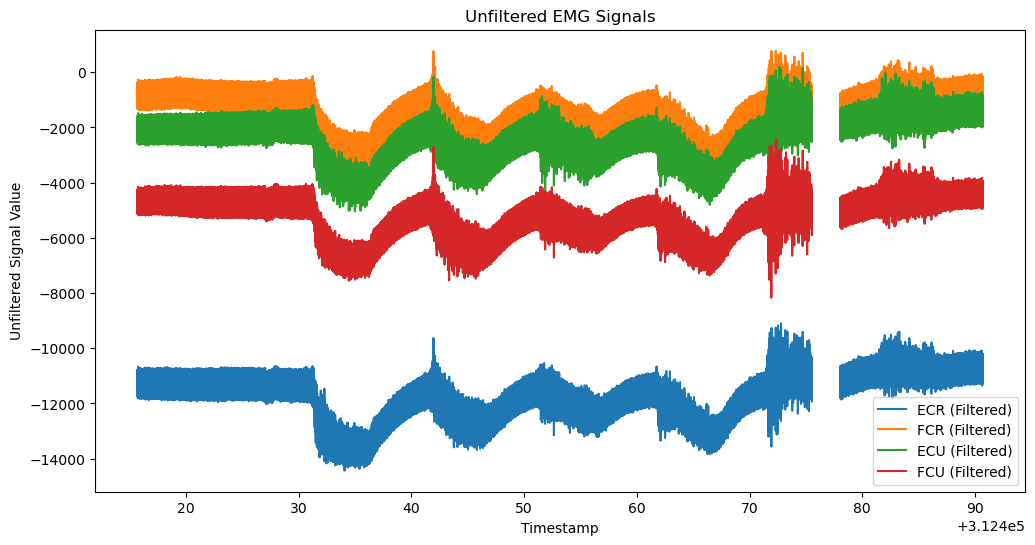

In [8]:
fs = 1000  # Replace with your actual sampling frequency
t = emg_data_ex['TimeStamp'].values

# Plot the filtered signals
plt.figure(figsize=(12, 6))
for column in emg_data_ex.columns[1:]:
    plt.plot(t, emg_data_ex[column], label=f'{column} (Filtered)')

plt.title('Unfiltered EMG Signals')
plt.xlabel('Timestamp')
plt.ylabel('Unfiltered Signal Value')
plt.legend()
plt.show()

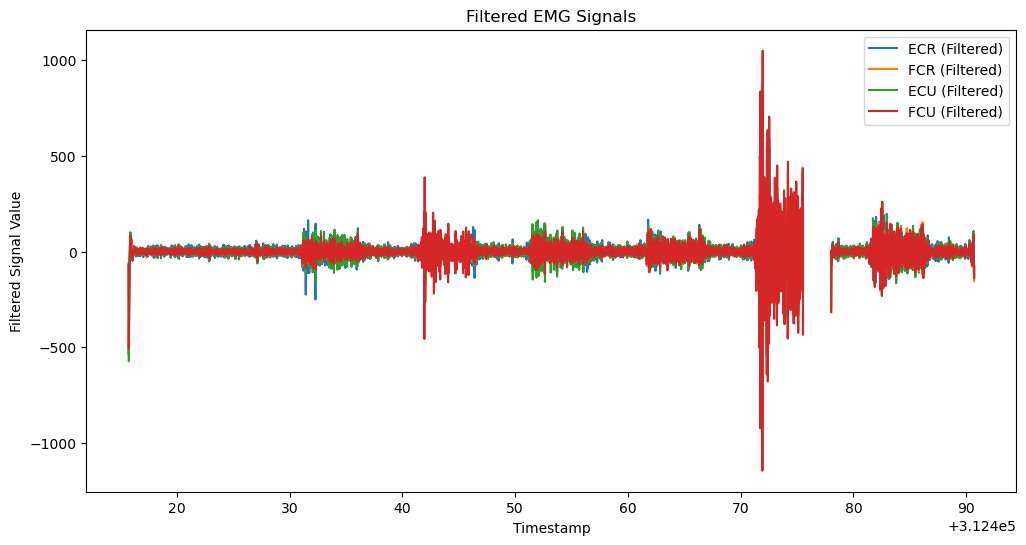

In [10]:
from scipy.signal import butter, filtfilt

fs = 1000  # Replace with your actual sampling frequency
t = emg_data_ex['TimeStamp'].values

# Function to apply a bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Function to apply a notch filter
def notch_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Apply the filters to each EMG channel
for column in emg_data_ex.columns[1:]:  # Assuming the first column is timestamp
    emg_data_ex[column] = notch_filter(emg_data_ex[column].values, cutoff=50, fs=fs)
    emg_data_ex[column] = bandpass_filter(emg_data_ex[column].values, lowcut=3, highcut=30, fs=fs)

# Plot the filtered signals
plt.figure(figsize=(12, 6))
for column in emg_data_ex.columns[1:]:
    plt.plot(t, emg_data_ex[column], label=f'{column} (Filtered)')

plt.title('Filtered EMG Signals')
plt.xlabel('Timestamp')
plt.ylabel('Filtered Signal Value')
plt.legend()
plt.show()

In [11]:
# Define the labeled segments
labels = ['rest', 'rest', 'rest', 'wrist extension', 'rest', 'wrist flexion', 'rest', 'ulnar deviation',
          'rest', 'radial deviation', 'rest', 'punch', 'rest', 'open hand', 'rest']

# Set the duration of each segment (in seconds)
segment_duration = 5

# Convert irregular timestamps to a continuous index starting from 0
emg_data_ex['time_index'] = emg_data_ex['TimeStamp'] - emg_data_ex['TimeStamp'].min()

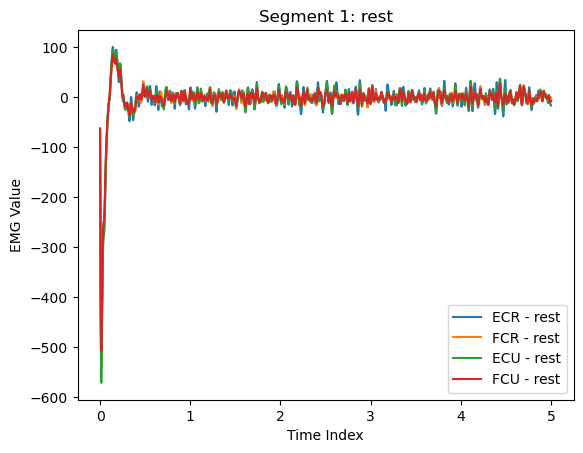

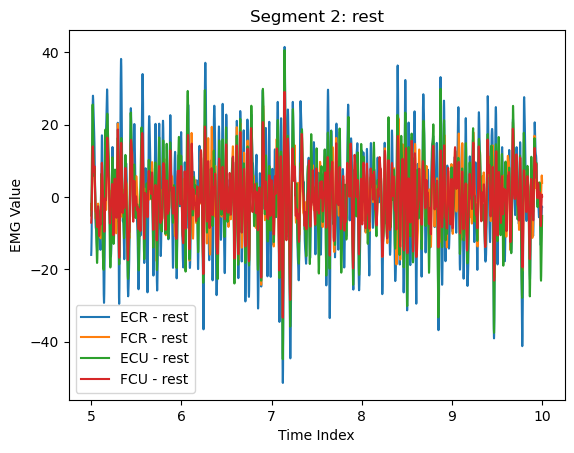

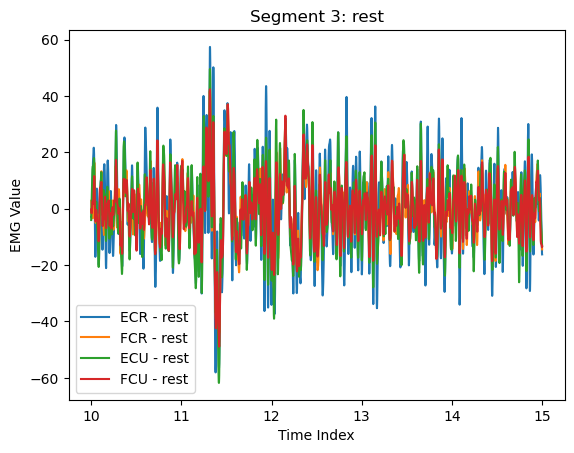

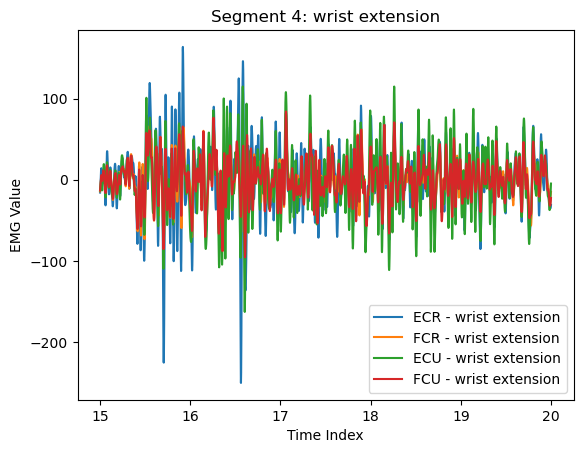

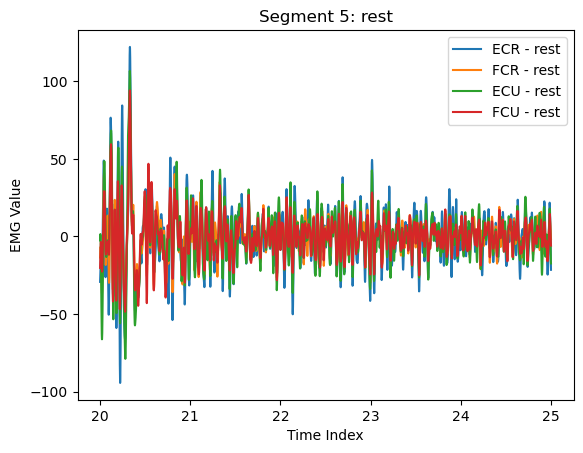

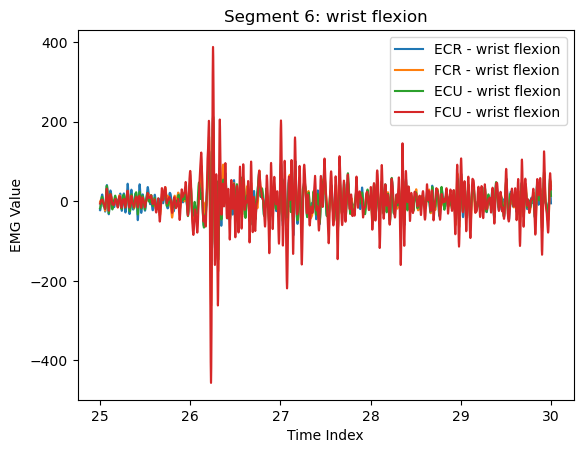

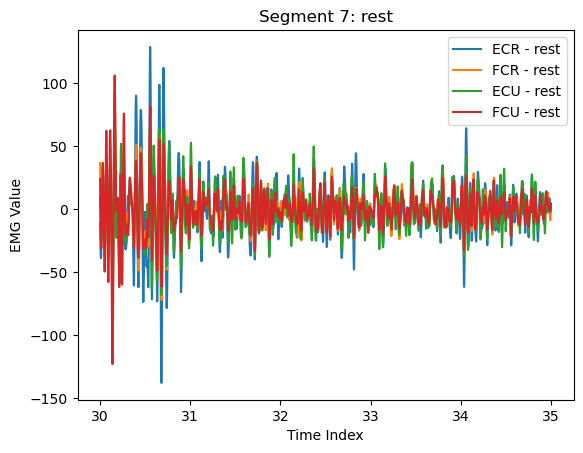

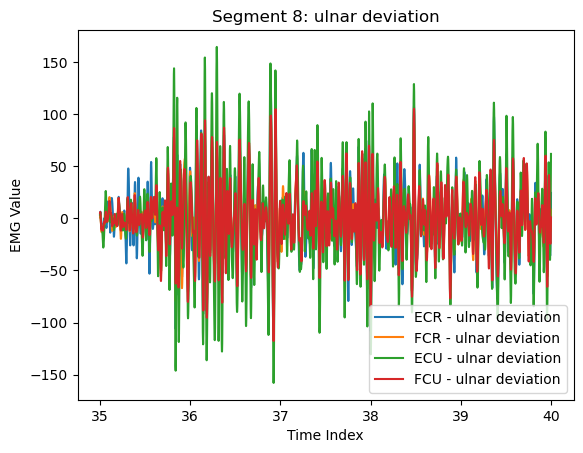

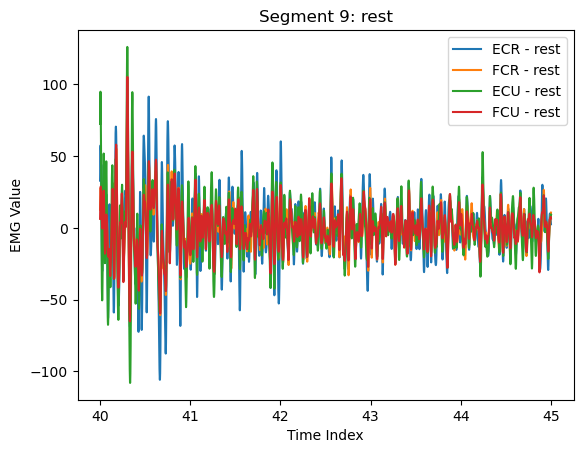

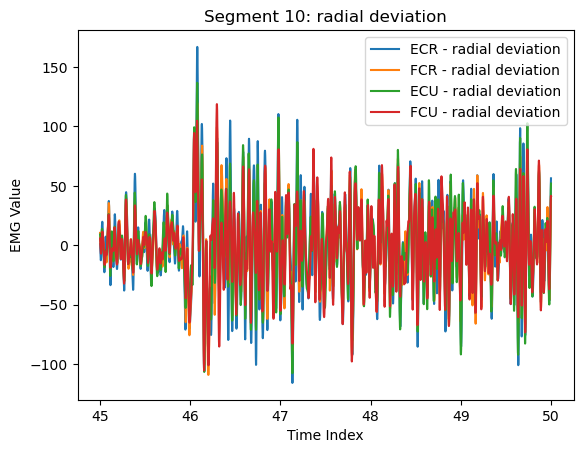

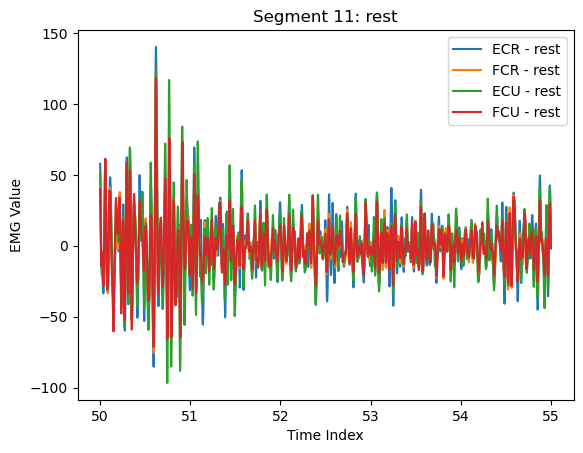

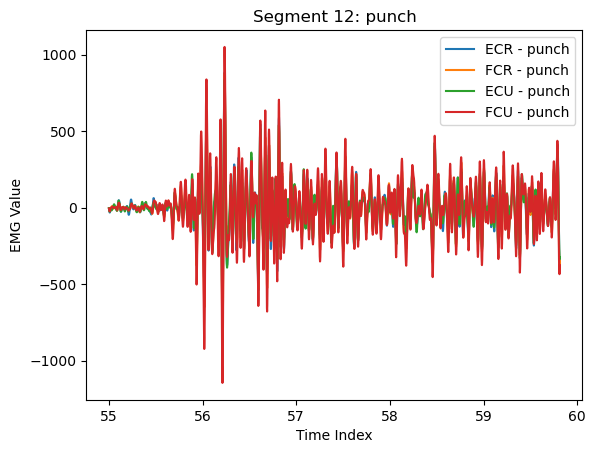

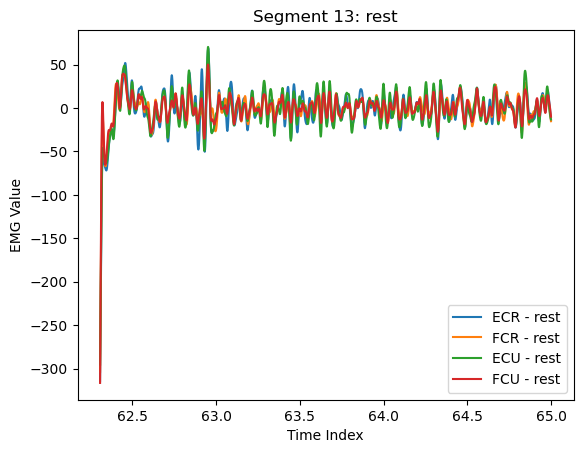

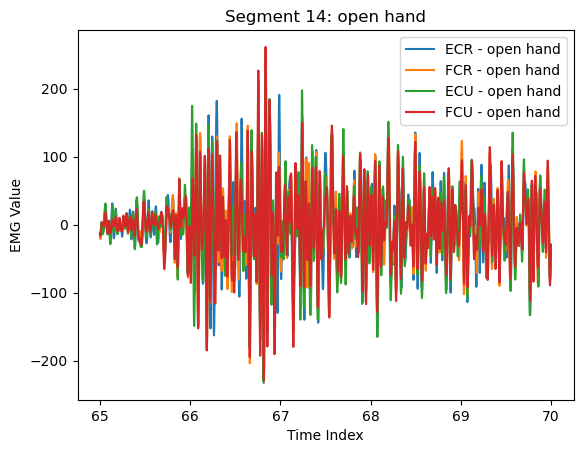

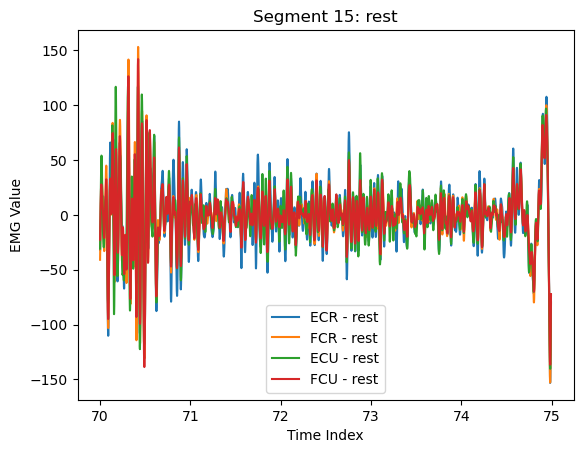

Processing complete.


In [12]:
# Plot each labeled segment
for index, label in enumerate(labels):
    start_time = index * segment_duration
    end_time = (index + 1) * segment_duration

    # Extract the segment from the EMG data for each channel
    segment = emg_data_ex[(emg_data_ex['time_index'] >= start_time) & (emg_data_ex['time_index'] < end_time)]

    # Plot the segment for each channel
    channels = ['ECR', 'FCR', 'ECU', 'FCU']
    for channel in channels:
        plt.plot(segment['time_index'], segment[channel], label=f'{channel} - {label}')

    plt.xlabel('Time Index')
    plt.ylabel('EMG Value')
    plt.title(f'Segment {index + 1}: {label}')
    plt.legend()
    plt.show()

print("Processing complete.")

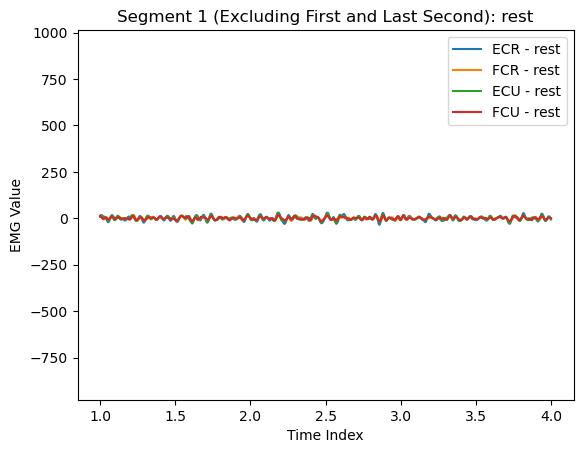

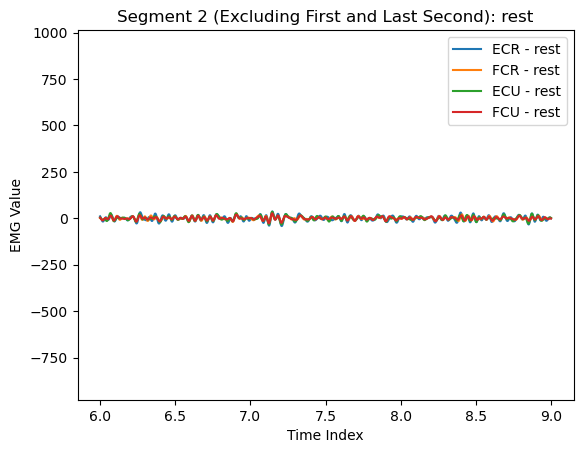

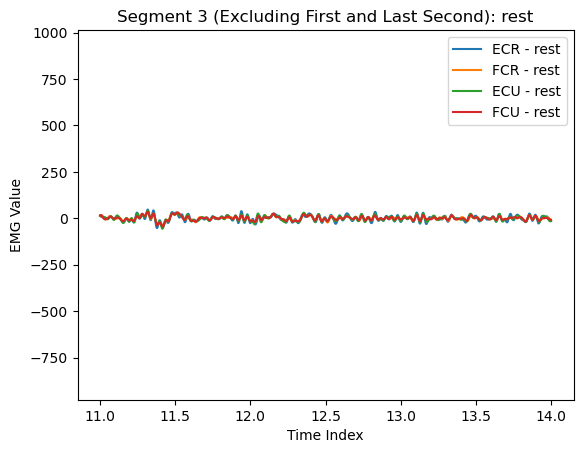

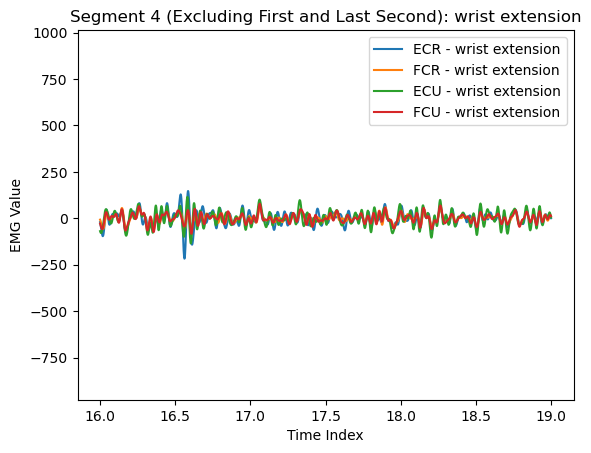

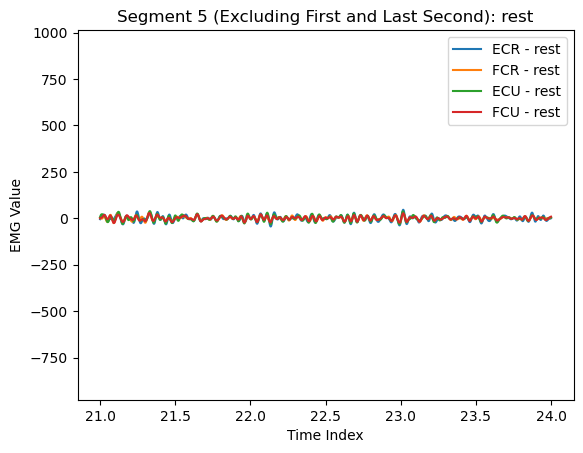

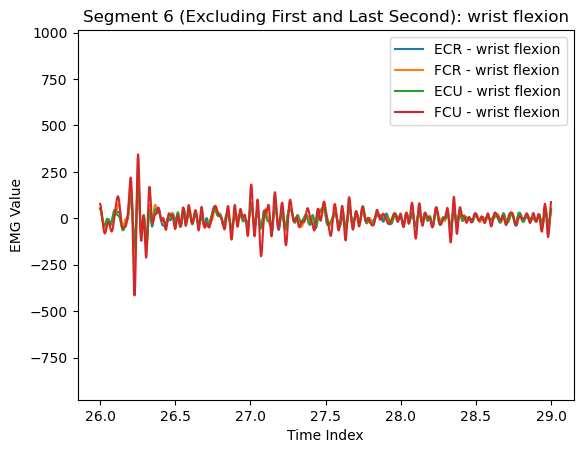

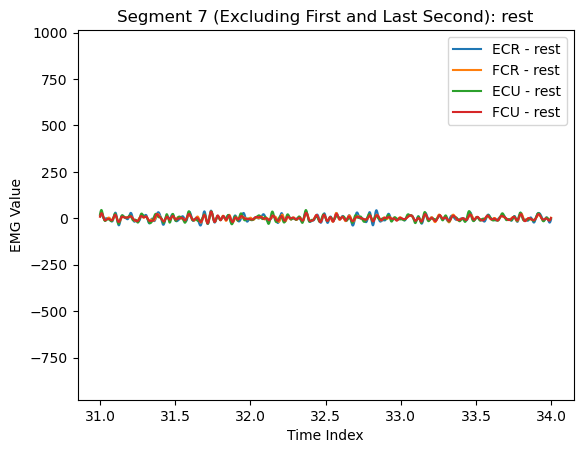

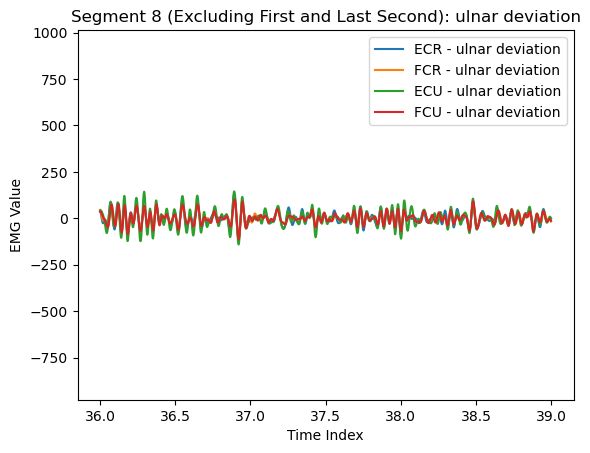

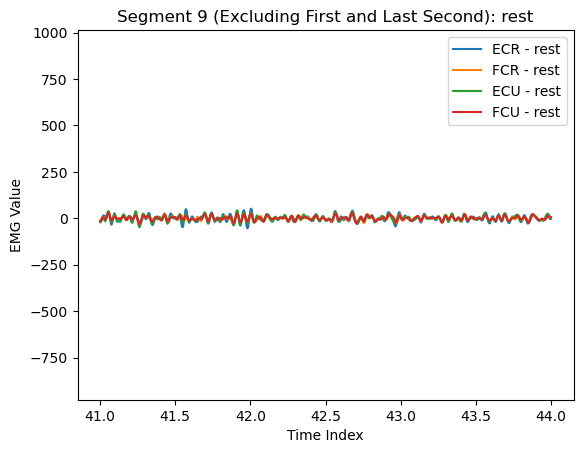

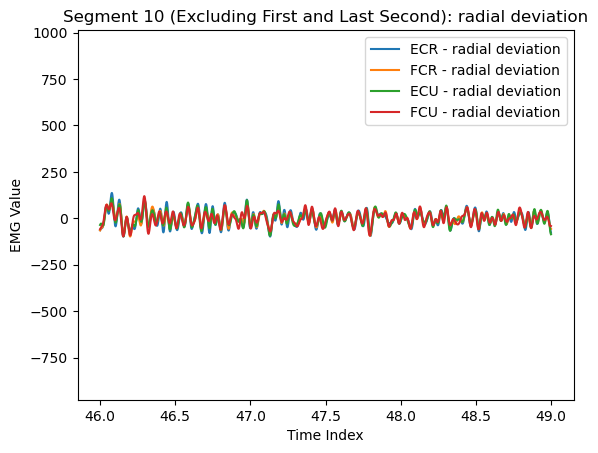

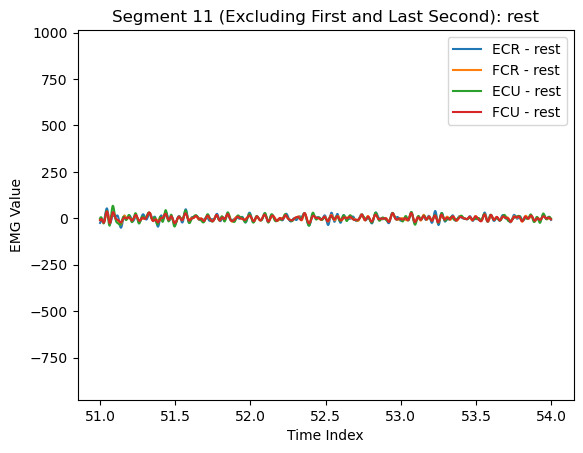

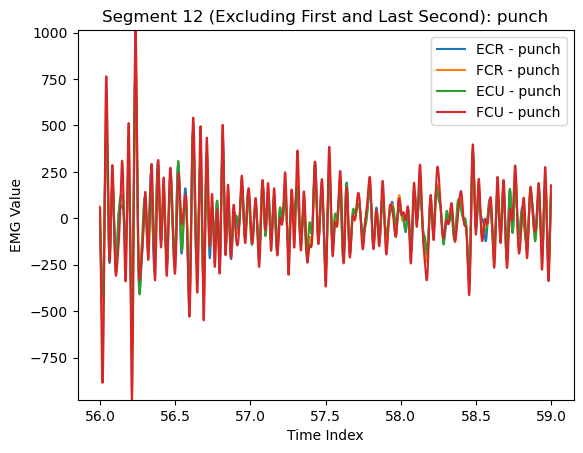

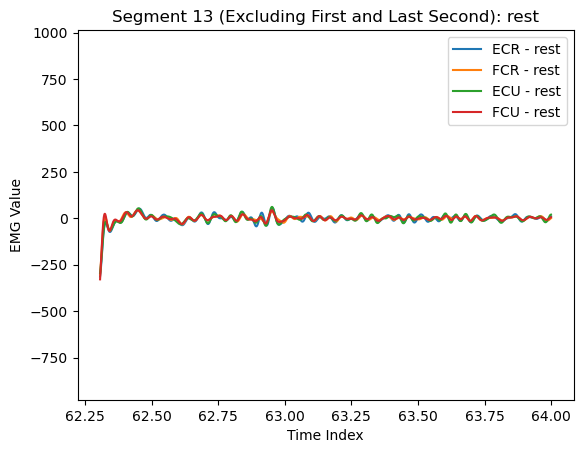

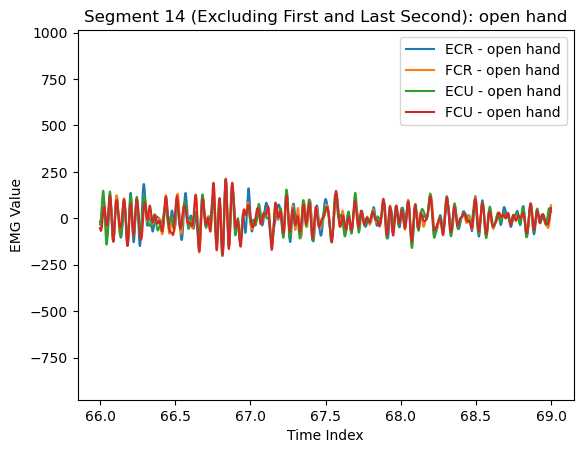

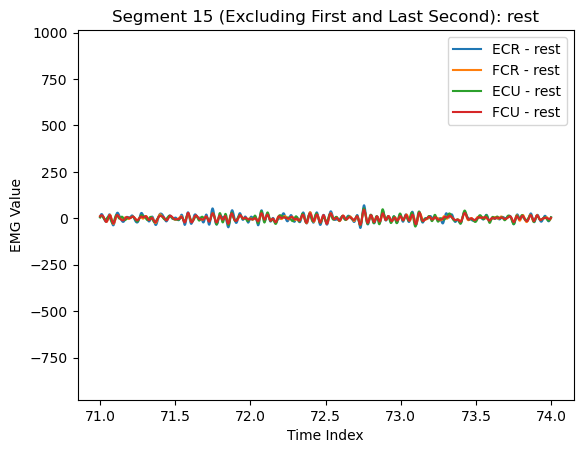

Processing complete.


In [34]:
# Plot each labeled segment after excluding the first and last seconds with identical y-scale
for index, label in enumerate(labels):
    start_time = index * segment_duration + 1  # excluding the first second
    end_time = (index + 1) * segment_duration - 1  # excluding the last second

    # Extract the segment from the EMG data for each channel
    segment = emg_data[(emg_data['time_index'] >= start_time) & (emg_data['time_index'] < end_time)]

    # Plot the segment for each channel with identical y-scale
    channels = ['ECR', 'FCR', 'ECU', 'FCU']
    for channel in channels:
        plt.plot(segment['time_index'], segment[channel], label=f'{channel} - {label}')

    plt.xlabel('Time Index')
    plt.ylabel('EMG Value')
    plt.title(f'Segment {index + 1} (Excluding First and Last Second): {label}')
    plt.legend()
    
    # Set identical y-scale for all plots
    plt.ylim(emg_data[channels].min().min(), emg_data[channels].max().max())

    plt.show()

print("Processing complete.")

In [38]:
# Function to segment EMG data and save segments
def segment_and_save(emg_data, labels, output_dir, segment_duration=5, fs=1000):
    emg_data['time_index'] = emg_data['TimeStamp'] - emg_data['TimeStamp'].min()

    # Apply bandpass filter to each channel
    channels = ['ECR', 'FCR', 'ECU', 'FCU']
    for channel in channels:
        emg_data[channel] = bandpass_filter(emg_data[channel], lowcut=20, highcut=500, fs=fs)

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Create a CSV file to store segment labels
    labels_csv_path = os.path.join(output_dir, 'segment_labels.csv')
    labels_df = pd.DataFrame(columns=['Recording', 'Segment', 'Label'])

    # Segment and save each labeled segment
    for index, label in enumerate(labels):
        start_time = index * segment_duration + 1  # excluding the first second
        end_time = (index + 1) * segment_duration - 1  # excluding the last second

        # Extract the segment from the EMG data for each channel
        segment = emg_data[(emg_data['time_index'] >= start_time) & (emg_data['time_index'] < end_time)]

        # Save the segment as a CSV file
        segment_filename = f"segment_{index + 1}.csv"
        segment_path = os.path.join(output_dir, segment_filename)
        segment.to_csv(segment_path, index=False)

        # Add the label to the labels DataFrame
        labels_df = labels_df.append({'Recording': recording_name, 'Segment': segment_filename, 'Label': label},
                                     ignore_index=True)

    # Save the labels CSV file
    labels_df.to_csv(labels_csv_path, index=False)

In [42]:
import os
import shutil
import pandas as pd

# Define input and output directories
input_base_dir = '/Users/ekinyilmaz/Desktop/mentalab/segments'
output_merged_dir = '/Users/ekinyilmaz/Desktop/mentalab/merged_segments'

# Create the output directory if it doesn't exist
os.makedirs(output_merged_dir, exist_ok=True)

# Function to merge segments from different folders
def merge_segments(input_base_dir, output_merged_dir):
    # Initialize an empty DataFrame to store merged labels
    merged_labels_df = pd.DataFrame(columns=['Recording', 'Segment', 'Label'])

    # Iterate over folders
    for folder_number in range(1, 6):  # Assuming folders are named emg_data1, emg_data2, ..., emg_data5
        folder_name = f'emg_data{folder_number}'
        folder_path = os.path.join(input_base_dir, folder_name)

        # Load segment labels CSV
        labels_csv_path = os.path.join(folder_path, 'segment_labels.csv')
        labels_df = pd.read_csv(labels_csv_path)

        # Iterate over segments in each folder
        for index, row in labels_df.iterrows():
            segment_number = index + 1
            segment_name_old = f'segment_{segment_number}.csv'

            # Rename segments to include folder number in the name
            segment_name_new = f'segment_{segment_number}_{folder_number}.csv'

            # Copy the segment to the merged directory with the new name
            shutil.copy(os.path.join(folder_path, segment_name_old), os.path.join(output_merged_dir, segment_name_new))

            # Update the labels DataFrame with the new segment name and folder
            labels_df.at[index, 'Segment'] = segment_name_new
            labels_df.at[index, 'Recording'] = f'emg_data{folder_number}'

        # Append the labels for the current folder to the merged_labels_df
        merged_labels_df = pd.concat([merged_labels_df, labels_df])

    # Save the combined labels CSV file in the output merged directory
    merged_labels_csv_path = os.path.join(output_merged_dir, 'combined_segment_labels.csv')
    merged_labels_df.to_csv(merged_labels_csv_path, index=False)

# Merge segments from different folders
merge_segments(input_base_dir, output_merged_dir)


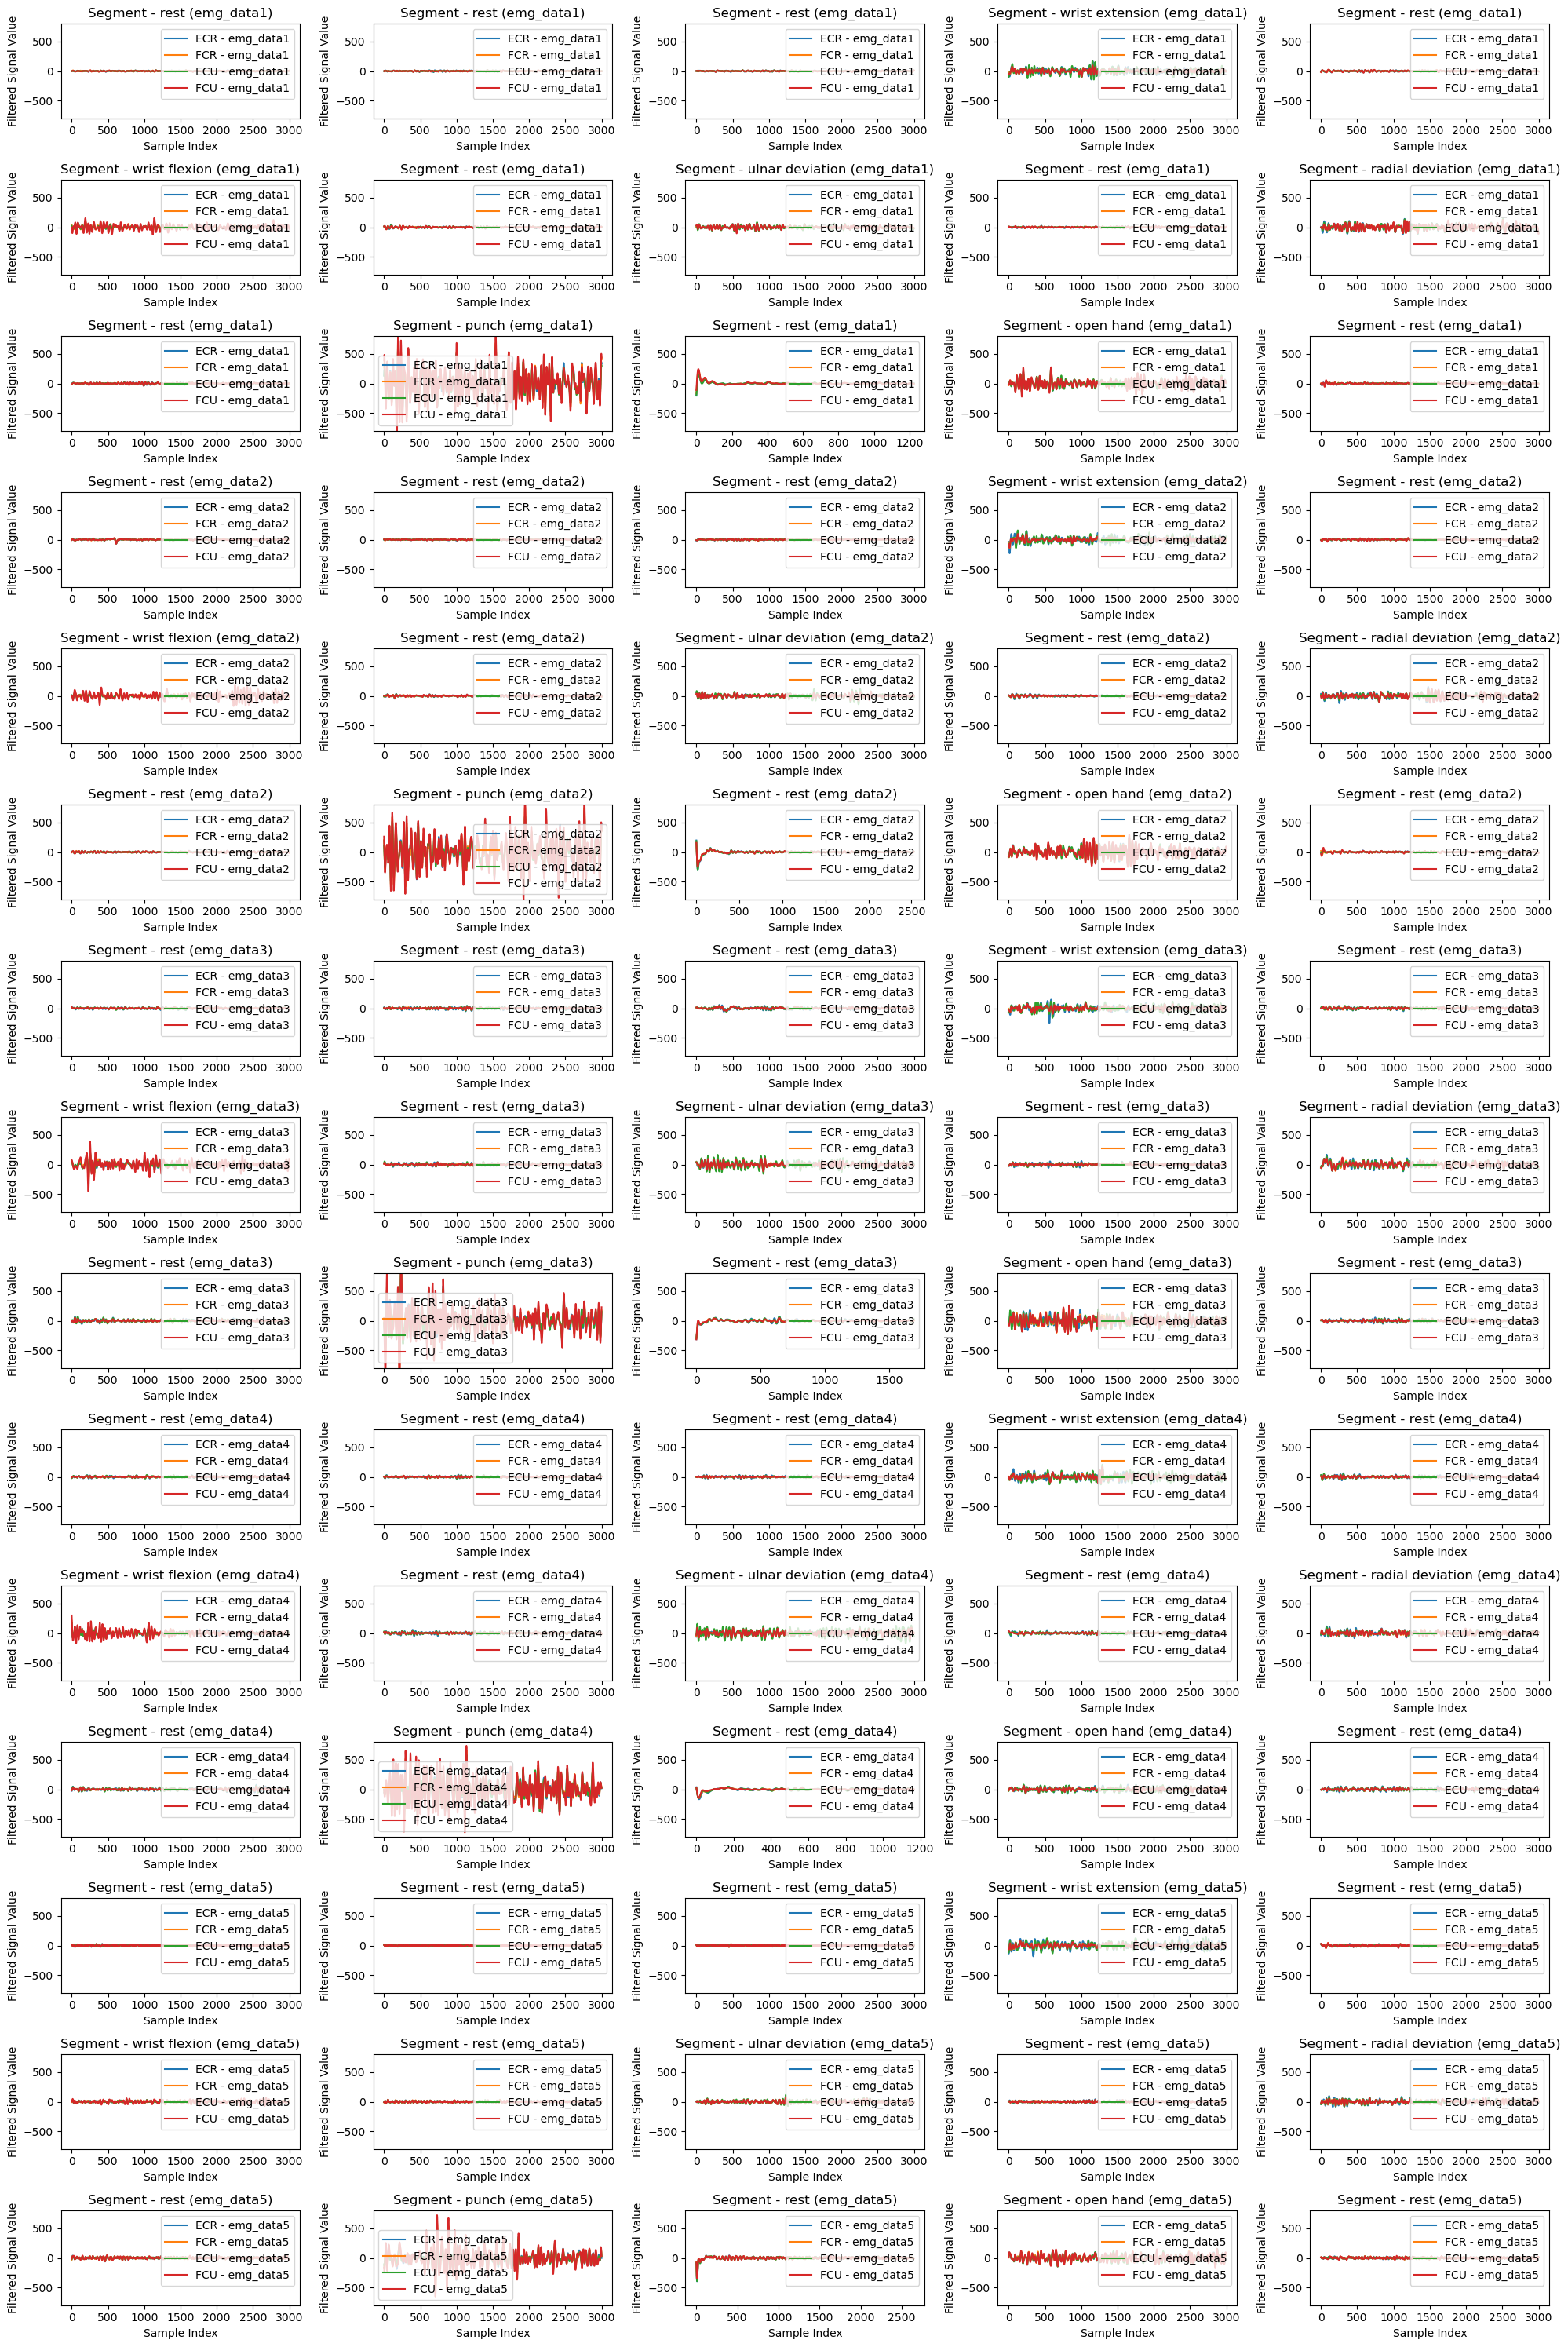

In [44]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the merged directory
merged_dir = '/Users/ekinyilmaz/Desktop/mentalab/merged_segments'

# Load the combined labels CSV file
combined_labels_csv_path = os.path.join(merged_dir, 'combined_segment_labels.csv')
combined_labels_df = pd.read_csv(combined_labels_csv_path)

# Function to plot segments with labels in a grid
def plot_segments_with_labels_grid(merged_dir, combined_labels_df):
    # Define channels to plot
    channels_to_plot = ['ECR', 'FCR', 'ECU', 'FCU']

    # Set the number of rows and columns in the grid
    num_rows = 15
    num_columns = 5

    # Set y-axis limits
    y_limits = (-800, 800)  # Adjust as needed based on your data

    # Create a subplot grid
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 30))

    # Iterate over segments in the combined labels DataFrame
    for index, row in combined_labels_df.iterrows():
        recording_name = row['Recording']
        segment_name = row['Segment']
        label = row['Label']

        # Load the segment CSV file
        segment_path = os.path.join(merged_dir, segment_name)
        segment_data = pd.read_csv(segment_path)

        # Plot each channel
        ax = axes[index // num_columns, index % num_columns]
        for channel in channels_to_plot:
            ax.plot(segment_data[channel], label=f'{channel} - {recording_name}')

        ax.set_title(f'Segment - {label} ({recording_name})')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Filtered Signal Value')
        ax.legend()

        # Set y-axis limits for each subplot
        ax.set_ylim(y_limits)

    # Adjust layout to prevent clipping of subplot titles and labels
    plt.tight_layout()

    # Show the plots
    plt.show()

# Plot segments with labels in a grid
plot_segments_with_labels_grid(merged_dir, combined_labels_df)


In [45]:
import pandas as pd

# Replace 'path/to/your/emg_recording.csv' with the actual path to your CSV file
csv_file_path = '/Users/ekinyilmaz/Desktop/mentalab/merged_segments/segment_1_1.csv'

# Read the CSV file into a DataFrame
emg_data = pd.read_csv(csv_file_path)

# Select the relevant columns (ECR, FCR, ECU, FCU)
channels_to_select = ['ECR', 'FCR', 'ECU', 'FCU']
selected_data = emg_data[channels_to_select]

# Convert the selected data to a 2D array
emg_array = selected_data.to_numpy()

# Print the shape of the resulting 2D array
print(f"Shape of the 2D array: {emg_array.shape}")


Shape of the 2D array: (3000, 4)


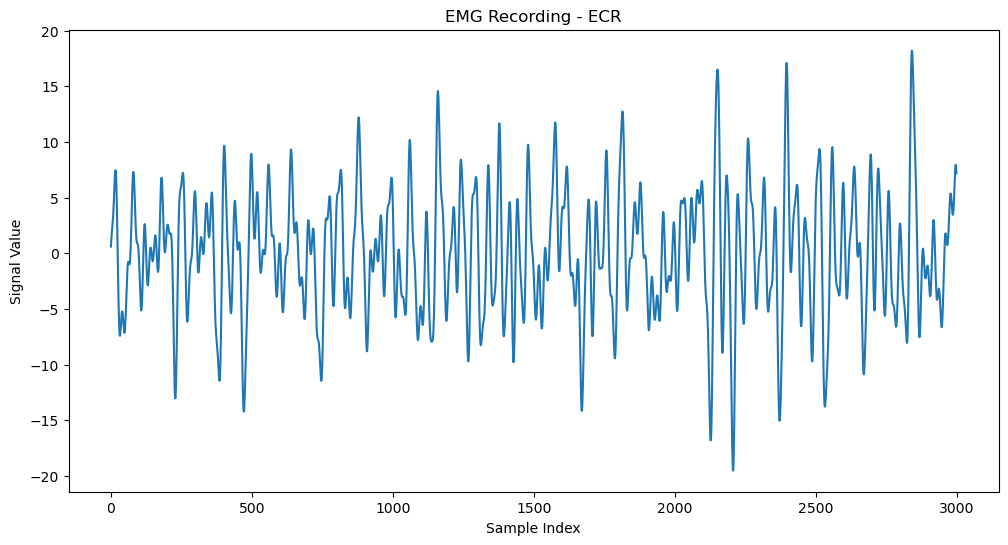

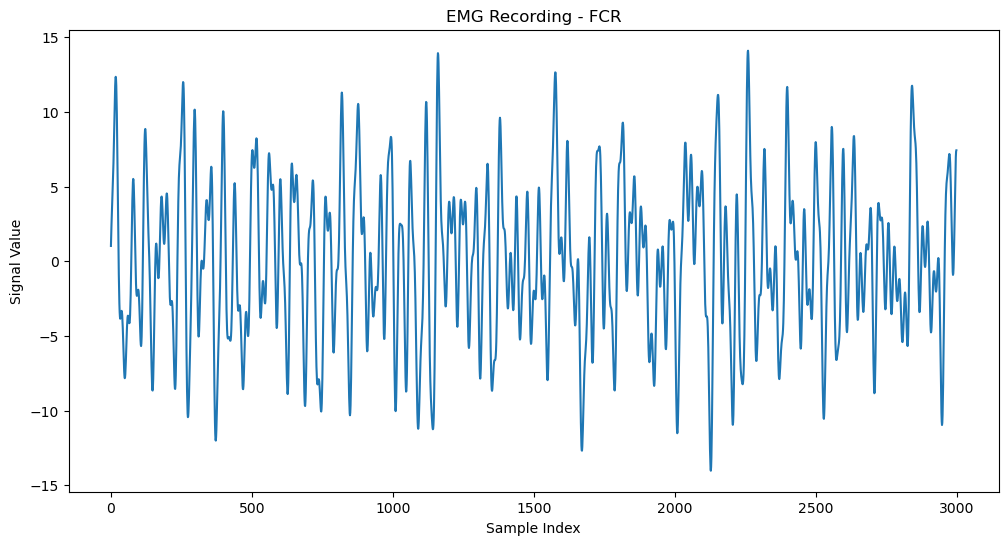

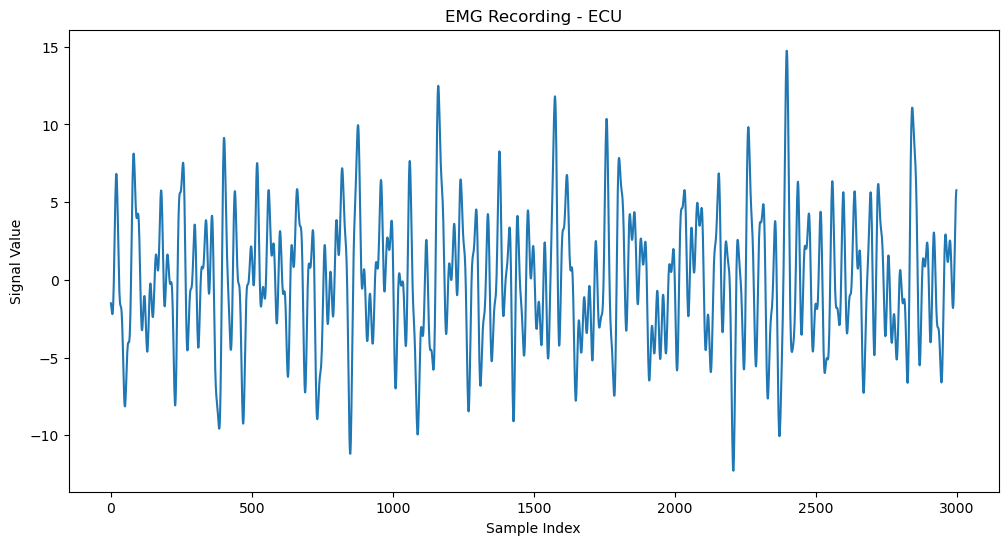

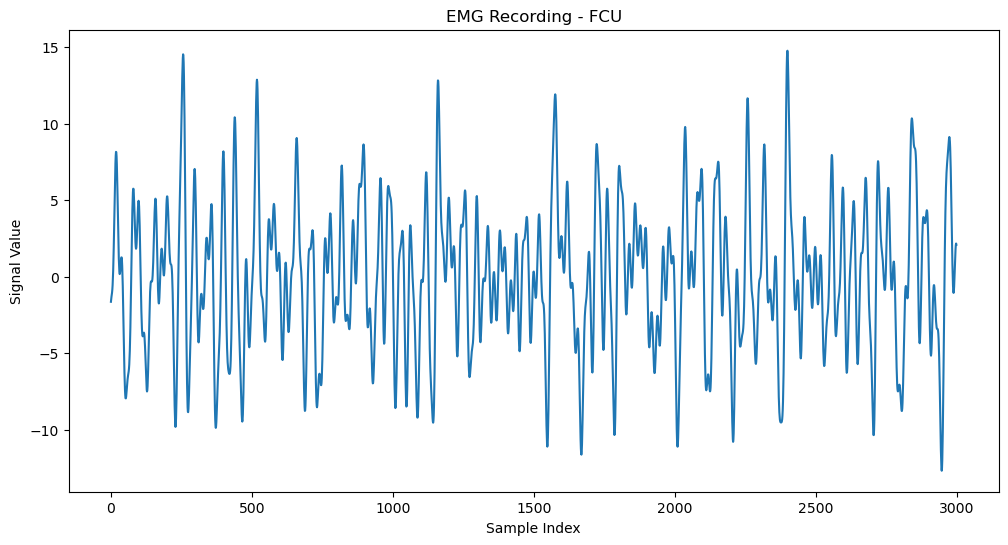

In [46]:
# Plot each channel separately
for i, channel in enumerate(channels_to_select):
    plt.figure(figsize=(12, 6))
    plt.plot(emg_array[:, i])
    plt.title(f'EMG Recording - {channel}')
    plt.xlabel('Sample Index')
    plt.ylabel('Signal Value')
    plt.show()

File Name: segment_1_1.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_1_2.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_1_3.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_1_4.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_1_5.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_2_1.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_2_2.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_2_3.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_2_4.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_2_5.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_3_1.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_3_2.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_3_3.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_3_4.csv
Label: rest
Size of EMG Array: (3000, 4)


File Name: segment_3

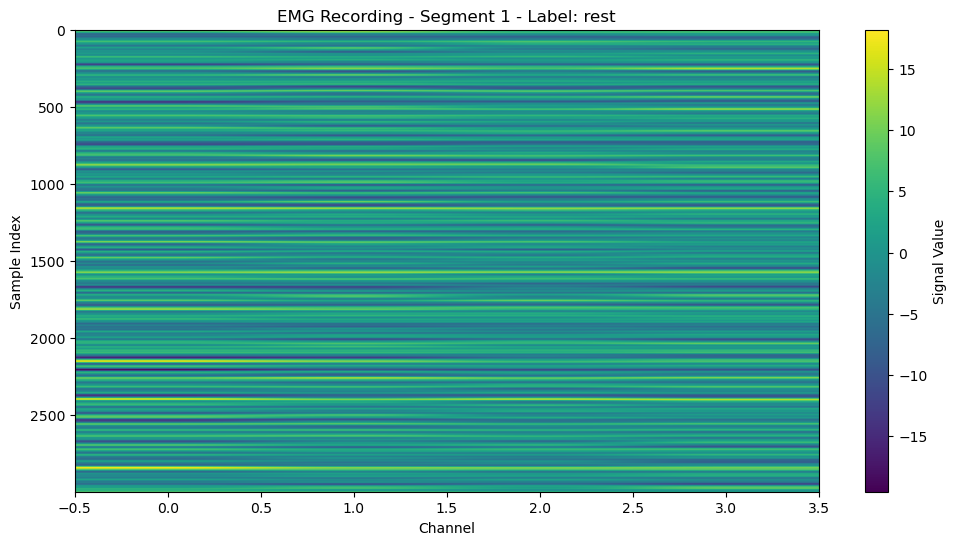

In [130]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the merged directory
merged_dir = '/Users/ekinyilmaz/Desktop/mentalab/merged_segments'

# Load the combined labels CSV file
combined_labels_csv_path = os.path.join(merged_dir, 'combined_segment_labels.csv')
combined_labels_df = pd.read_csv(combined_labels_csv_path)

# Define channels to select
channels_to_select = ['ECR', 'FCR', 'ECU', 'FCU']

# Define the order of movement numbers
movement_order = [1, 2, 3, 5, 7, 9, 11, 13, 15, 4, 6, 8, 10, 12, 14]

# Create a list to store dictionaries for each segment
segment_data_list = []

# Create a list to store dictionaries with file names, labels, and EMG arrays
data_for_csv = []

# Iterate over the specified order of movement numbers
for movement_number in movement_order:
    # Iterate over segments in the combined labels DataFrame
    for index, row in combined_labels_df.iterrows():
        recording_name = row['Recording']
        segment_name = row['Segment']
        label = row['Label']

        # Extract movement number from the segment name
        _, current_movement, _ = segment_name.split('_')
        current_movement = int(current_movement)

        # Check if the current segment matches the current movement number
        if current_movement == movement_number:
            # Load the segment CSV file
            segment_path = os.path.join(merged_dir, segment_name)
            segment_data = pd.read_csv(segment_path)

            # Select the relevant columns (ECR, FCR, ECU, FCU)
            selected_data = segment_data[channels_to_select]

            # Convert the selected data to a 2D array and append to the list
            emg_array = selected_data.to_numpy()

            # Store data in a dictionary along with label and file name
            segment_data_dict = {
                'File Name': segment_name,
                'Label': label,
                'EMG_Array': emg_array
            }

            segment_data_list.append(segment_data_dict)

            # Append data dictionary for writing to CSV
            data_for_csv.append(segment_data_dict)

# Example: Display labels, file names, and sizes
for segment_data_dict in segment_data_list:
    file_name = segment_data_dict['File Name']
    label = segment_data_dict['Label']
    emg_array = segment_data_dict['EMG_Array']
    
    print(f"File Name: {file_name}")
    print(f"Label: {label}")
    print(f"Size of EMG Array: {emg_array.shape}")
    print("\n")

# Example: Plot the 2D array for the first segment
plt.figure(figsize=(12, 6))
plt.imshow(segment_data_list[0]['EMG_Array'], aspect='auto', cmap='viridis')
plt.title(f'EMG Recording - Segment 1 - Label: {segment_data_list[0]["Label"]}')
plt.xlabel('Channel')
plt.ylabel('Sample Index')
plt.colorbar(label='Signal Value')
plt.show()

# Write file names, labels, and EMG arrays to a CSV file
csv_output_path = os.path.join(merged_dir, 'file_names_labels_and_arrays.csv')
csv_df = pd.DataFrame(data_for_csv)
csv_df.to_csv(csv_output_path, index=False)



In [131]:
# Assuming you've already executed the script to create segment_arrays

# Check the number of segments appended
num_segments = len(segment_arrays)
print(f"Number of segments: {num_segments}")

# Check the size (shape) of each segment array
if num_segments > 0:
    # Assuming all arrays have the same shape (adjust if needed)
    shape_of_first_segment = segment_arrays[0].shape
    print(f"Shape of each segment array: {shape_of_first_segment}")
else:
    print("No segments appended yet.")


Number of segments: 75
Shape of each segment array: (3000, 4)


In [132]:
import numpy as np

# Assuming you have a list 'segment_arrays' with 75 EMG segment arrays
# Each array has the shape (3000, 4)

# Concatenate the arrays in the list vertically
combined_emg_array = np.vstack(segment_arrays)

# Print the shape of the combined array
print(f"Shape of the combined EMG array: {combined_emg_array.shape}")


Shape of the combined EMG array: (219266, 4)


In [69]:
# For most systems or networks it is not possible to make sense out of one single timestamp but rather over an interval of samples called windows.
# We want to generate windows of 128 samples out of the recordings and have a time overlap of 50% of each window.

# Write a function that extracts windows of the described shape from the dataset (use at least one subject).

def extract_windows(signals, window_size, overlap):
    """
    To extract windows from given EMG signals
    
    Inputs:
    - signals: 2D array, EMG signals (samples x channels)
    - window_size: int, size of each window samplewise
    - overlap: float, overlap ratio (0 no overlap 1 total overlap may create problem with zero division?? )

    Returns:
    - windows: 3D array, windows (num_windows x window_size x num_channels)
    """

    num_samples, num_channels = signals.shape
    print(f"num_samples:", {num_samples})
    print(f"num_channels:", {num_channels})
    
    step_size = int(round(window_size * (1 - overlap + 1e-100)))
    print(f"steps_size:", {step_size})
    
    num_windows = int((num_samples - window_size) / step_size) + 1 #len(sequence) - window_size + 1 to stop on window size
    print(f"num_windows:", {num_windows})
    
    windows = np.zeros((num_windows,window_size,num_channels)) #(num_matrix,row,col)
    print(f"windows' shape (num_windows x window_size x num_channels):", {windows.shape})
    
    #for i in range(0, num_windows*step_size, step_size):
        #windows[:, :, i] = signals[i:i+window_size, :]

    for i in range(num_windows):
        start = i * step_size #start = i * (step_size-1)
        end = start + window_size
        # Start and end indices shown
        print(f"Window {i + 1}: start={start}, end={end}")
        windows[i, :, :] = signals[start:end,]

    return windows

In [133]:
emg_merged = combined_emg_array
windows = extract_windows(emg_merged, window_size = 100, overlap = 0.5) 
print(windows)

num_samples: {219266}
num_channels: {4}
steps_size: {50}
num_windows: {4384}
windows' shape (num_windows x window_size x num_channels): {(4384, 100, 4)}
Window 1: start=0, end=100
Window 2: start=50, end=150
Window 3: start=100, end=200
Window 4: start=150, end=250
Window 5: start=200, end=300
Window 6: start=250, end=350
Window 7: start=300, end=400
Window 8: start=350, end=450
Window 9: start=400, end=500
Window 10: start=450, end=550
Window 11: start=500, end=600
Window 12: start=550, end=650
Window 13: start=600, end=700
Window 14: start=650, end=750
Window 15: start=700, end=800
Window 16: start=750, end=850
Window 17: start=800, end=900
Window 18: start=850, end=950
Window 19: start=900, end=1000
Window 20: start=950, end=1050
Window 21: start=1000, end=1100
Window 22: start=1050, end=1150
Window 23: start=1100, end=1200
Window 24: start=1150, end=1250
Window 25: start=1200, end=1300
Window 26: start=1250, end=1350
Window 27: start=1300, end=1400
Window 28: start=1350, end=1450
W

In [72]:
# Select and implement 14 features. Compute each feature for each EMG channels individually.

# signals: 2D array, EMG signals (samples x channels)
# windows: 3D array, extracted windows (num_windows x window_size x num_channels)
# transposed : 3D array, extracted windows (num_windows x num_channels x window_size)

from scipy.stats import skew, kurtosis
from scipy import stats, signal

# Extract features for single channel.
def extract_features(channel_data):
    # mean absolute value
    mean_abs_value = np.mean(np.abs(channel_data))
    
    # root means square
    rms_value = np.sqrt(np.mean(np.square(channel_data)))
    
    # waveform length
    waveform_length = np.sum(np.diff(channel_data))
    
    # integral absolute value
    integral_abs_value = np.sum(np.abs(channel_data))
    
    # skewness
    skewness_value = skew(channel_data)
    
    # variance
    variance = np.var(channel_data)
    
    # zero crossing
    
    # kurtosis
    kurtosis_value = kurtosis(channel_data)
    
    # energy
    energy = np.sum(channel_data ** 2)
    
    #  Difference Absolute Standard Deviation Value
    dasdv = np.sqrt(np.mean(np.square(np.diff(channel_data))))
    
    # log-detector
    #log_det = np.exp(np.mean(np.log(np.abs(channel_data))))
    
    # simple square integral
    ssi = np.sum(np.square(channel_data))

    freq, power = signal.periodogram(channel_data, 5120) #5120 is the number of points to use in the FFT.
    
    # mean power
    mean_power = np.mean(power, axis=0)
    
    # mean frequency
    mean_freq = np.sum(power*freq, axis=0) / np.sum(power, axis=0)
    
    #peak frequency
    peak_freq = freq[np.argmax(power, axis=0)]
    
    # power spectrum deformation
    def sm(order):
        return np.sum(power * np.power(freq, order), axis=0)
    ohm = np.sqrt(sm(2)/sm(0)) / (sm(1)/sm(0))
    
    return mean_abs_value, rms_value, integral_abs_value, variance, energy, dasdv, ssi, mean_power, kurtosis_value, skewness_value, mean_freq, peak_freq, waveform_length, ohm

In [73]:
# Extract features from EMG data, windows' shape (num_windows x window_size x num_channels): (1151, 128, 256)
num_windows = windows.shape[0]
num_channels = windows.shape[2]
num_features = 14 # manual entry, might need to update it

feature_matrix = np.zeros((num_windows, num_channels, num_features))
print(feature_matrix.shape)

transposed_windows = windows.transpose(0,2,1)
print(transposed_windows.shape)

(4384, 4, 14)
(4384, 4, 100)


In [74]:
# Iterate through each channel in each window, it takes some time to calculate longer than 2 mins
for window_index in range(num_windows):
    for channel_index in range(num_channels):
        channel_data = transposed_windows[window_index,channel_index,:]
        channel_features = extract_features(channel_data)
        feature_matrix[window_index, channel_index,:] = channel_features
        
print(feature_matrix.shape)  #feature matrix shape = num_windows (1151) x num_channels (256) x num_features(14)

(4384, 4, 14)


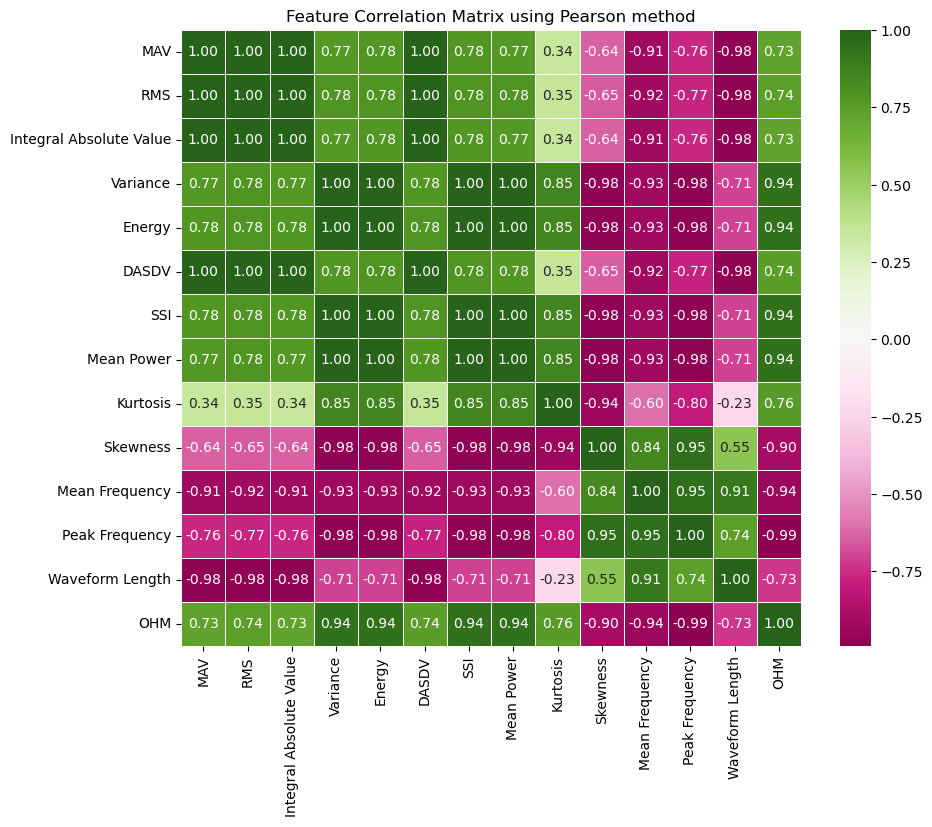

In [75]:
# Compute the feature correlation matrix with the python library pandas. Plot the correlation matrix and briefly mention which features you would use.

feature_names = ["MAV", "RMS", "Integral Absolute Value", "Variance", "Energy", "DASDV", "SSI", "Mean Power","Kurtosis","Skewness","Mean Frequency","Peak Frequency", "Waveform Length", "OHM"]

df = pd.DataFrame(np.mean(feature_matrix, axis=0), columns = feature_names) 

# Compute the correlation matrix, default pearson method is used here
correlation_matrix = df.corr() 

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="PiYG", fmt=".2f", linewidths=.5)
plt.title("Feature Correlation Matrix using Pearson method")
plt.show()

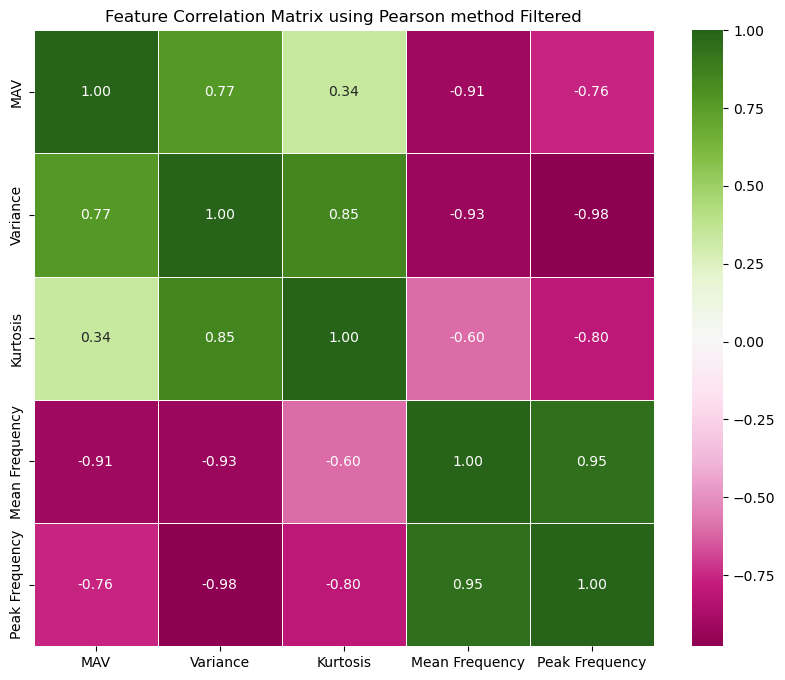

{'Mean Power', 'Integral Absolute Value', 'OHM', 'Waveform Length', 'RMS', 'Energy', 'DASDV', 'Skewness', 'SSI'}


In [81]:
# Remove highly correlated features, keep at least 5 features, if not increase the threshold slightly.
threshold = 0.98 # provided in the assignment
highly_correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

# Drop highly correlated features from the DataFrame
df_filtered = df.drop(columns=highly_correlated_features)

# Display the DataFrame after removing highly correlated features
#print("\nDataFrame after removing highly correlated features:")
#print(df_filtered)

# Compute the correlation matrix, default pearson method is used here
correlation_matrix_filtered = df_filtered.corr() 

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_filtered, annot=True, cmap="PiYG", fmt=".2f", linewidths=.5)
plt.title("Feature Correlation Matrix using Pearson method Filtered")
plt.show()

print(highly_correlated_features)

In [82]:
feature_names = ["MAV", "RMS", "Integral Absolute Value", "Variance", "Energy", "DASDV", "SSI", "Mean Power", "Kurtosis", "Skewness", "Mean Frequency", "Peak Frequency", "Waveform Length", "OHM"]

# Features to delete
features_to_delete = ['Mean Power', 'Peak Frequency', 'Energy', 'SSI', 'RMS', 'Integral Absolute Value']

# Remove specified features
for feature in features_to_delete:
    if feature in feature_names:
        feature_names.remove(feature)

print("Updated feature_names:", feature_names)

Updated feature_names: ['MAV', 'Variance', 'DASDV', 'Kurtosis', 'Skewness', 'Mean Frequency', 'Waveform Length', 'OHM']


In [83]:
array_3d = feature_matrix

array_2d = array_3d.reshape(-1, array_3d.shape[-1])

columns = ["MAV", "RMS", "Integral Absolute Value", "Variance", "Energy", "DASDV", "SSI", "Mean Power","Kurtosis","Skewness","Mean Frequency","Peak Frequency", "Waveform Length", "OHM"]

df_ekin = pd.DataFrame(array_2d, columns=columns)

columns_to_drop = highly_correlated_features

df_dropped = df_ekin.drop(columns=columns_to_drop)

# Convert DataFrame back to NumPy array
array_after_drop = df_dropped.values.reshape(array_3d.shape[0], array_3d.shape[1], -1)

#print("Original 3D Array:")
#print(array_3d)

#print("\nDataFrame from 3D Array:")
#print(df_ekin)

#print("\nDataFrame after dropping columns:")
#print(df_dropped)

#print("\nNumPy array after dropping columns:")
#print(array_after_drop)

print("\nShape of feature matrix after dropping columns:")
print(array_after_drop.shape)


Shape of feature matrix after dropping columns:
(4384, 4, 5)


In [105]:
print(emg_merged.shape)
print(type(labels))
# Convert the list into a NumPy array
labels_array = np.array(labels)

# Print the resulting array
print(labels_array)
print(labels_array.shape)

(219266, 4)
<class 'list'>
['rest' 'rest' 'rest' 'wrist extension' 'rest' 'wrist flexion' 'rest'
 'ulnar deviation' 'rest' 'radial deviation' 'rest' 'punch' 'rest'
 'open hand' 'rest']
(15,)


In [107]:
import numpy as np

# Define the length of the 1D array
length = 75 * 3000

# Create a 1D array initialized with zeros
my_1d_array = np.zeros(length, dtype=int)

# Set the elements as specified
my_1d_array[:45 * 3000] = 0
my_1d_array[45 * 3000:50 * 3000] = 1
my_1d_array[50 * 3000:55 * 3000] = 2
my_1d_array[55 * 3000:60 * 3000] = 3
my_1d_array[60 * 3000:65 * 3000] = 4
my_1d_array[65 * 3000:70 * 3000] = 5
my_1d_array[70 * 3000:] = 6

# Print the resulting array
print(my_1d_array.shape)


(225000,)


In [ ]:



#oversampled_labels = np.repeat(labels_array, 4)
print(oversampled_labels.shape)

reshaped_data = emg_merged.reshape((-1, 5))
print(reshaped_data.shape)

In [101]:
X=emg_merged
y=labels_array
print(X.shape)
print(y.shape)




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape)

(219266, 4)
(15,)


ValueError: Found input variables with inconsistent numbers of samples: [219266, 15]